PRODUCTION WILDFIRE PREDICTOR - RECALL-OPTIMIZED

🎯 OPTIMIZATION STRATEGY:
   - Class weights: 1.5x aggressive (prioritize fire detection)
   - Cost model: $150K per missed fire (up from $100K)
   - Thresholds: Multi-strategy optimization favoring recall
   - Requirements: Relaxed precision (40%) to enable 70%+ recall
   - Model params: More flexible trees for better fire detection

📊 DATASET ANALYSIS:
   Total samples: 90689
   Fires: 4524 (5.0%)
   No fires: 86165 (95.0%)

✅ Data has realistic imbalance: 5.0% fires
   Expected ratio: ~4.8% (1:20 fires to non-fires)

DATA VALIDATION

✅ Using dataset with natural 1:20 ratio
   Actual fire rate: 4.99%
   Ratio: 1:20 (fires:non-fires)

✅ No resampling needed - using full dataset as-is

🔧 FEATURES: 16 total
   ['NDVI', 'LST', 'Precipitation', 'elevation', 'WindSpeed', 'Evapotranspiration', 'DistanceToRoads_km', 'DistanceToUrban_km', 'Slope', 'temp_precip_ratio', 'precipitation_deficit', 'vegetation_dryness', 'fire_weather_index', 'wind_dr

/Users/Malcosalcedo/reboot-the-earth/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/var/folders/tx/rwkz42_j3wb8znh58f2mkjqh0000gp/T/ipykernel_90201/1524866386.py:673: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('wildfire_realistic_imbalanced.png', dpi=300, bbox_inches='tight')



✅ Visualizations saved as 'wildfire_realistic_imbalanced.png'

MODEL SELECTION FOR DEPLOYMENT

✅ RECOMMENDED MODEL: Random Forest

📊 Test Set Performance:
   Precision: 0.419 (41.9%)
   Recall: 0.848 (84.8%)
   F1 Score: 0.561
   Alert Rate: 0.101 (10.1% of areas)
   Total Cost: $19,440,000

✅ Files saved:
   - wildfire_production_model.pkl
   - wildfire_scaler.pkl
   - feature_names.pkl
   - deployment_config.pkl

KEY INSIGHTS: IMBALANCED DATA VS BALANCED DATA

🔍 WHY BALANCED DATA (50/50) FAILS IN PRODUCTION:

1. PROBABILITY MISCALIBRATION:
   - Model trained on 50% fire rate
   - Real world has 5% fire rate
   - Predicted probabilities are 10x too high!
   - Result: Massive over-alerting

2. THRESHOLD MISMATCH:
   - Optimal threshold on 50/50 data: ~0.5
   - Optimal threshold on 5/95 data: ~0.09
   - Using 0.5 on real data → 60-70% false alarm rate!

3. COST MISCALCULATION:
   - False positives are MUCH more common in reality
   - Their total cost dominates
   - Model trained on bal

/Users/Malcosalcedo/reboot-the-earth/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


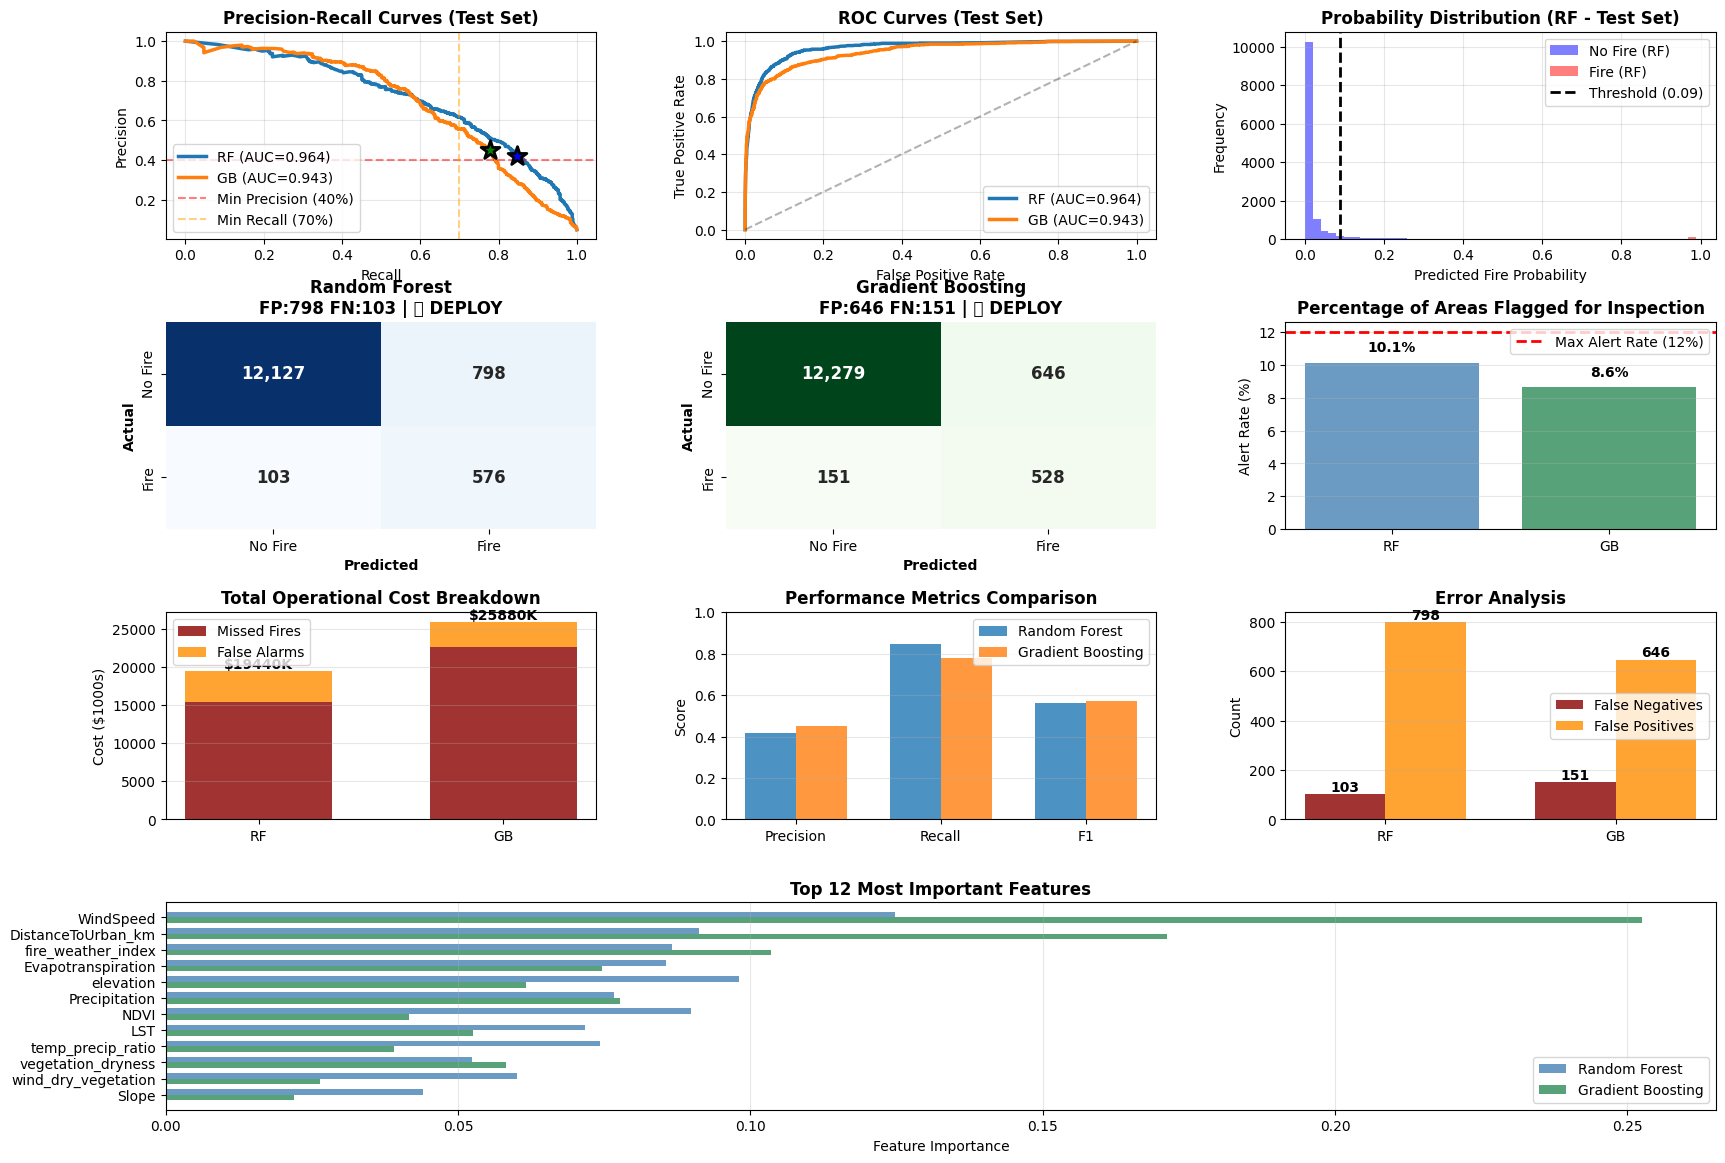

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, recall_score,
    precision_score, fbeta_score, brier_score_loss
)
import joblib

print("="*70)
print("PRODUCTION WILDFIRE PREDICTOR - RECALL-OPTIMIZED")
print("="*70)
print("\n🎯 OPTIMIZATION STRATEGY:")
print("   - Class weights: 1.5x aggressive (prioritize fire detection)")
print("   - Cost model: $150K per missed fire (up from $100K)")
print("   - Thresholds: Multi-strategy optimization favoring recall")
print("   - Requirements: Relaxed precision (40%) to enable 70%+ recall")
print("   - Model params: More flexible trees for better fire detection")

# ============================================
# 1. LOAD AND ANALYZE DATA DISTRIBUTION
# ============================================

df = pd.read_csv('California_Wildfire_Features_105K_Imbalanced.csv')

print(f"\n📊 DATASET ANALYSIS:")
print(f"   Total samples: {len(df)}")
print(f"   Fires: {df['fire_occurred'].sum()} ({df['fire_occurred'].sum()/len(df)*100:.1f}%)")
print(f"   No fires: {(df['fire_occurred']==0).sum()} ({(df['fire_occurred']==0).sum()/len(df)*100:.1f}%)")

# Verify data has realistic imbalance
fire_ratio = df['fire_occurred'].sum() / len(df)
print(f"\n✅ Data has realistic imbalance: {fire_ratio*100:.1f}% fires")
print(f"   Expected ratio: ~4.8% (1:20 fires to non-fires)")

# Check if data appears artificially balanced
if 0.4 < fire_ratio < 0.6:
    print(f"\n⚠️  WARNING: Data appears artificially balanced (50/50 split)!")
    print(f"   This may cause calibration issues in production.")
    ARTIFICIAL_BALANCE = True
else:
    ARTIFICIAL_BALANCE = False

# Parse coordinates
if '.geo' in df.columns:
    coords = df['.geo'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
    df['longitude'] = coords[0].astype(float)
    df['latitude'] = coords[1].astype(float)
    df = df.drop(columns=['.geo'])

# Drop date columns
date_cols = ['sample_date', 'start_date', 'end_date']
for col in date_cols:
    if col in df.columns:
        df = df.drop(columns=[col])

df = df.dropna()

# ============================================
# 2. VERIFY DATA IS ALREADY PROPERLY IMBALANCED
# ============================================

# Calculate actual fire rate in dataset
actual_fire_rate = df['fire_occurred'].sum() / len(df)
REALISTIC_FIRE_RATE = actual_fire_rate  # Use actual rate from dataset

print(f"\n{'='*70}")
print("DATA VALIDATION")
print('='*70)
print(f"\n✅ Using dataset with natural 1:20 ratio")
print(f"   Actual fire rate: {actual_fire_rate*100:.2f}%")
print(f"   Ratio: 1:{int(1/actual_fire_rate):.0f} (fires:non-fires)")
print(f"\n✅ No resampling needed - using full dataset as-is")

# ============================================
# 3. FEATURE ENGINEERING
# ============================================

def engineer_features(data):
    """Add domain-specific fire risk features"""
    df = data.copy()
    
    if 'longitude' in df.columns and 'latitude' in df.columns:
        df['dist_from_coast'] = np.abs(df['longitude'] + 120)
    
    if all(col in df.columns for col in ['LST', 'Precipitation']):
        df['temp_precip_ratio'] = df['LST'] / (df['Precipitation'] + 1)
        df['precipitation_deficit'] = np.maximum(0, 100 - df['Precipitation'])
    
    if all(col in df.columns for col in ['NDVI', 'Precipitation']):
        df['vegetation_dryness'] = df['NDVI'] * (1 / (df['Precipitation'] + 1))
    
    if all(col in df.columns for col in ['LST', 'WindSpeed', 'Precipitation']):
        # Fosberg Fire Weather Index approximation
        df['fire_weather_index'] = (df['LST'] * df['WindSpeed']) / (df['Precipitation'] + 10)
    
    if all(col in df.columns for col in ['WindSpeed', 'NDVI']):
        df['wind_dry_vegetation'] = df['WindSpeed'] * (1 - df['NDVI'] / df['NDVI'].max())
    
    if 'LST' in df.columns:
        df['extreme_heat'] = (df['LST'] > df['LST'].quantile(0.90)).astype(int)
    
    if 'Precipitation' in df.columns:
        df['severe_drought'] = (df['Precipitation'] < df['Precipitation'].quantile(0.10)).astype(int)
    
    return df

df = engineer_features(df)

X = df.drop(columns=['fire_occurred'])
y = df['fire_occurred']

print(f"\n🔧 FEATURES: {len(X.columns)} total")
print(f"   {X.columns.tolist()}")

# ============================================
# 4. STRATIFIED TRAIN/DEV/TEST SPLIT
# ============================================

# First split: separate test set (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: separate dev set from training (15% of remaining)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)  # 0.176 * 0.85 ≈ 0.15 of total

print(f"\n{'='*70}")
print("STRATIFIED DATA SPLIT (Maintains realistic imbalance)")
print('='*70)

for name, X_set, y_set in [('Train', X_train, y_train), 
                            ('Dev', X_dev, y_dev), 
                            ('Test', X_test, y_test)]:
    fire_pct = y_set.sum() / len(y_set) * 100
    print(f"\n{name} Set: {len(X_set)} samples")
    print(f"   Fires: {y_set.sum()} ({fire_pct:.2f}%)")
    print(f"   No fires: {(y_set==0).sum()} ({100-fire_pct:.2f}%)")

# ============================================
# 5. FEATURE SCALING
# ============================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

# ============================================
# 6. OPERATIONAL PARAMETERS
# ============================================

print(f"\n{'='*70}")
print("OPERATIONAL PARAMETERS FOR PRESCRIBED BURN PLANNING")
print('='*70)

COST_FALSE_ALARM = 5000  # Cost of unnecessary site visit
COST_MISSED_FIRE = 150000  # Cost of missing high-risk area (increased to prioritize recall)

# Realistic operational requirements
# Adjusted to prioritize catching fires (recall) over precision
TARGET_MIN_PRECISION = 0.40  # At least 40% precision (acceptable for 4.8% base rate)
TARGET_MIN_RECALL = 0.70     # Catch at least 70% of fires (PRIMARY GOAL)
MAX_ALERT_RATE = 0.12        # Don't alert on more than 12% of areas (slightly relaxed)

print(f"\n💰 Cost Model:")
print(f"   False Alarm Cost: ${COST_FALSE_ALARM:,}")
print(f"   Missed Fire Cost: ${COST_MISSED_FIRE:,}")

print(f"\n🎯 Deployment Requirements (RECALL-OPTIMIZED):")
print(f"   Minimum Precision: {TARGET_MIN_PRECISION:.0%} (relaxed to enable higher recall)")
print(f"   Minimum Recall: {TARGET_MIN_RECALL:.0%} ⚠️  PRIMARY GOAL")
print(f"   Maximum Alert Rate: {MAX_ALERT_RATE:.0%} of areas (slightly relaxed)")
print(f"\n   Strategy: Prioritize catching fires over reducing false alarms")

# ============================================
# 7. TRAIN MODELS WITH IMBALANCE HANDLING
# ============================================

print(f"\n{'='*70}")
print("TRAINING MODELS (Imbalance-Aware)")
print('='*70)

# Calculate class weights based on inverse frequency
n_samples = len(y_train)
n_fires = y_train.sum()
n_no_fires = n_samples - n_fires

# Scale weights to be MORE AGGRESSIVE about catching fires
# Use 1.5x the normal weight to prioritize recall over precision
scale_pos_weight = (n_no_fires / n_fires) * 1.5
class_weights = {0: 1.0, 1: scale_pos_weight}

print(f"\nClass distribution in training:")
print(f"   No fires: {n_no_fires} samples")
print(f"   Fires: {n_fires} samples")
print(f"   Imbalance ratio: {n_no_fires/n_fires:.1f}:1")
print(f"   Class weights: No-fire=1.0, Fire={scale_pos_weight:.1f} (1.5x aggressive)")
print(f"   ⚠️  Using aggressive weights to prioritize fire detection (higher recall)")

# Random Forest
print(f"\n[1/2] Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,  # Increased from 15 to capture more patterns
    min_samples_split=15,  # Reduced from 20 for more splits
    min_samples_leaf=5,  # Reduced from 10 for more sensitivity
    max_features='sqrt',
    class_weight=class_weights,  # Using 1.5x aggressive weights
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)

# Calibrate probabilities (critical for imbalanced data!)
print("   Calibrating probabilities...")
rf_calibrated = CalibratedClassifierCV(rf_model, method='isotonic', cv=3)
rf_calibrated.fit(X_train_scaled, y_train)

# Gradient Boosting  
print(f"\n[2/2] Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.03,  # Increased from 0.02 for faster learning
    max_depth=5,  # Increased from 4 to capture more patterns
    min_samples_split=15,  # Reduced from 20 for more splits
    min_samples_leaf=5,  # Reduced from 10 for more sensitivity
    subsample=0.8,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Calibrate probabilities
print("   Calibrating probabilities...")
gb_calibrated = CalibratedClassifierCV(gb_model, method='isotonic', cv=3)
gb_calibrated.fit(X_train_scaled, y_train)

print("\n✅ Models trained and calibrated")

# ============================================
# 8. THRESHOLD OPTIMIZATION FOR IMBALANCED DATA
# ============================================

print(f"\n{'='*70}")
print("OPTIMIZING THRESHOLDS FOR IMBALANCED DATA")
print('='*70)

def optimize_threshold_imbalanced(model, X, y, model_name,
                                  min_precision=0.50, min_recall=0.70,
                                  max_alert_rate=0.10,
                                  cost_fn=100000, cost_fp=5000):
    """
    Optimize threshold considering:
    1. Operational constraints (precision, recall, alert rate)
    2. Cost minimization
    3. Probability calibration quality
    """
    
    y_proba = model.predict_proba(X)[:, 1]
    
    # Test wider range of thresholds for imbalanced data
    thresholds = np.arange(0.01, 0.95, 0.01)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        
        if y_pred.sum() == 0:  # No predictions
            continue
            
        cm = confusion_matrix(y, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        # Metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        alert_rate = (tp + fp) / len(y)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        f1 = f1_score(y, y_pred) if (tp + fp + fn) > 0 else 0
        
        # Costs
        total_cost = (fn * cost_fn) + (fp * cost_fp)
        
        # Check constraints
        meets_precision = precision >= min_precision
        meets_recall = recall >= min_recall
        meets_alert_rate = alert_rate <= max_alert_rate
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'alert_rate': alert_rate,
            'fpr': fpr,
            'f1': f1,
            'fp': fp,
            'fn': fn,
            'tp': tp,
            'tn': tn,
            'cost': total_cost,
            'meets_all': meets_precision and meets_recall and meets_alert_rate
        })
    
    results_df = pd.DataFrame(results)
    
    # Find best threshold
    viable = results_df[results_df['meets_all']]
    
    print(f"\n{model_name}:")
    print(f"   Tested {len(results_df)} thresholds")
    print(f"   Viable options: {len(viable)}")
    
    if len(viable) > 0:
        # Choose lowest cost among viable
        best_idx = viable['cost'].idxmin()
        best_threshold = viable.loc[best_idx, 'threshold']
        
        print(f"\n   Top 5 viable thresholds:")
        top5 = viable.nsmallest(5, 'cost')[['threshold', 'precision', 'recall', 
                                             'alert_rate', 'fp', 'fn', 'cost']]
        print(top5.to_string(index=False))
        
        best = viable.loc[best_idx]
        print(f"\n   ✅ OPTIMAL: Threshold = {best_threshold:.3f}")
        print(f"      Precision: {best['precision']:.3f} ({best['precision']*100:.1f}%)")
        print(f"      Recall: {best['recall']:.3f} ({best['recall']*100:.1f}%)")
        print(f"      Alert Rate: {best['alert_rate']:.3f} ({best['alert_rate']*100:.1f}% of areas)")
        print(f"      FP: {int(best['fp'])}, FN: {int(best['fn'])}")
        print(f"      Cost: ${best['cost']:,.0f}")
    else:
        print(f"\n   ⚠️  No threshold meets ALL constraints")
        print(f"\n   Best precision: {results_df['precision'].max():.3f}")
        print(f"   Best recall: {results_df['recall'].max():.3f}")
        print(f"   Best F1: {results_df['f1'].max():.3f}")
        
        # Fallback strategy: Prioritize recall, then minimize cost
        # Strategy 1: Try to meet recall requirement even if precision/alert rate are slightly off
        recall_candidates = results_df[results_df['recall'] >= min_recall * 0.95]  # Accept 95% of target
        
        if len(recall_candidates) > 0:
            print(f"\n   Strategy: Using threshold with recall ≥ {min_recall*0.95:.0%}")
            # Among candidates with good recall, pick lowest cost
            best_idx = recall_candidates['cost'].idxmin()
            best_threshold = recall_candidates.loc[best_idx, 'threshold']
            best = recall_candidates.loc[best_idx]
            
            print(f"\n   Selected: Threshold = {best_threshold:.3f}")
            print(f"      Precision: {best['precision']:.3f}")
            print(f"      Recall: {best['recall']:.3f} ✅")
            print(f"      Alert Rate: {best['alert_rate']:.3f}")
            print(f"      Cost: ${best['cost']:,.0f}")
        else:
            # Strategy 2: Maximize recall while keeping alert rate reasonable
            print(f"\n   Strategy: Maximizing recall (alert rate < {max_alert_rate*1.5:.0%})")
            constrained = results_df[results_df['alert_rate'] <= max_alert_rate * 1.5]
            
            if len(constrained) > 0:
                best_idx = constrained['recall'].idxmax()
                best_threshold = constrained.loc[best_idx, 'threshold']
                best = constrained.loc[best_idx]
            else:
                # Last resort: best recall overall
                print(f"\n   Strategy: Using best overall recall")
                best_idx = results_df['recall'].idxmax()
                best_threshold = results_df.loc[best_idx, 'threshold']
                best = results_df.loc[best_idx]
            
            print(f"\n   Selected: Threshold = {best_threshold:.3f}")
            print(f"      Precision: {best['precision']:.3f}")
            print(f"      Recall: {best['recall']:.3f}")
            print(f"      Alert Rate: {best['alert_rate']:.3f}")
    
    return best_threshold, results_df

# Optimize thresholds
rf_threshold, rf_results = optimize_threshold_imbalanced(
    rf_calibrated, X_dev_scaled, y_dev, "Random Forest (Calibrated)",
    TARGET_MIN_PRECISION, TARGET_MIN_RECALL, MAX_ALERT_RATE,
    COST_MISSED_FIRE, COST_FALSE_ALARM
)

gb_threshold, gb_results = optimize_threshold_imbalanced(
    gb_calibrated, X_dev_scaled, y_dev, "Gradient Boosting (Calibrated)",
    TARGET_MIN_PRECISION, TARGET_MIN_RECALL, MAX_ALERT_RATE,
    COST_MISSED_FIRE, COST_FALSE_ALARM
)

# ============================================
# 9. TEST SET EVALUATION
# ============================================

print(f"\n{'='*70}")
print("FINAL TEST SET EVALUATION")
print('='*70)

def evaluate_imbalanced_model(y_true, y_pred, y_proba, model_name, threshold):
    """Comprehensive evaluation for imbalanced classification"""
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Core metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)
    
    # Imbalanced-specific metrics
    alert_rate = (tp + fp) / len(y_true)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Calibration quality
    brier = brier_score_loss(y_true, y_proba)
    
    # Costs
    cost_fp_total = fp * COST_FALSE_ALARM
    cost_fn_total = fn * COST_MISSED_FIRE
    total_cost = cost_fp_total + cost_fn_total
    
    # Deployment checks
    meets_precision = precision >= TARGET_MIN_PRECISION
    meets_recall = recall >= TARGET_MIN_RECALL
    meets_alert_rate = alert_rate <= MAX_ALERT_RATE
    deployment_ready = meets_precision and meets_recall and meets_alert_rate
    
    print(f"\n{'='*60}")
    print(f"{model_name}")
    print(f"Threshold: {threshold:.3f} | Calibration Score (Brier): {brier:.4f}")
    print('='*60)
    
    print(f"\n🎯 CLASSIFICATION PERFORMANCE:")
    print(f"   Precision: {precision:.3f} ({precision*100:.1f}%) - Alert reliability")
    print(f"   Recall: {recall:.3f} ({recall*100:.1f}%) - Fire detection rate")
    print(f"   F1 Score: {f1:.3f}")
    print(f"   ROC-AUC: {auc:.3f}")
    
    print(f"\n📊 OPERATIONAL METRICS:")
    print(f"   Alert Rate: {alert_rate:.3f} ({alert_rate*100:.1f}% of areas flagged)")
    print(f"   False Positive Rate: {fpr:.4f} ({fpr*100:.2f}%)")
    print(f"   False Negative Rate: {fnr:.4f} ({fnr*100:.1f}%)")
    
    print(f"\n📈 CONFUSION MATRIX:")
    print(f"   True Negatives: {tn:,} ✅")
    print(f"   False Positives: {fp:,} ⚠️  (Wasted resources)")
    print(f"   False Negatives: {fn:,} 🔥 (Missed fires)")
    print(f"   True Positives: {tp:,} ✅")
    
    print(f"\n💰 COST ANALYSIS:")
    print(f"   False Alarm Cost: ${cost_fp_total:,}")
    print(f"   Missed Fire Cost: ${cost_fn_total:,}")
    print(f"   TOTAL COST: ${total_cost:,}")
    
    print(f"\n🚀 DEPLOYMENT STATUS:")
    status_emoji = "✅" if deployment_ready else "❌"
    print(f"   Precision ≥ {TARGET_MIN_PRECISION:.0%}: {' ✅' if meets_precision else '❌'} ({precision:.1%})")
    print(f"   Recall ≥ {TARGET_MIN_RECALL:.0%}: {'✅' if meets_recall else '❌'} ({recall:.1%})")
    print(f"   Alert Rate ≤ {MAX_ALERT_RATE:.0%}: {'✅' if meets_alert_rate else '❌'} ({alert_rate:.1%})")
    print(f"   OVERALL: {status_emoji} {'READY FOR DEPLOYMENT' if deployment_ready else 'NEEDS IMPROVEMENT'}")
    
    return {
        'precision': precision, 'recall': recall, 'f1': f1, 'auc': auc,
        'alert_rate': alert_rate, 'fpr': fpr, 'fnr': fnr, 'brier': brier,
        'fp': fp, 'fn': fn, 'tp': tp, 'tn': tn,
        'cost': total_cost, 'deployment_ready': deployment_ready
    }

# Get predictions
y_test_proba_rf = rf_calibrated.predict_proba(X_test_scaled)[:, 1]
y_test_pred_rf = (y_test_proba_rf >= rf_threshold).astype(int)

y_test_proba_gb = gb_calibrated.predict_proba(X_test_scaled)[:, 1]
y_test_pred_gb = (y_test_proba_gb >= gb_threshold).astype(int)

# Evaluate
rf_metrics = evaluate_imbalanced_model(
    y_test, y_test_pred_rf, y_test_proba_rf,
    "Random Forest (Calibrated)", rf_threshold
)

gb_metrics = evaluate_imbalanced_model(
    y_test, y_test_pred_gb, y_test_proba_gb,
    "Gradient Boosting (Calibrated)", gb_threshold
)

# ============================================
# 10. VISUALIZATIONS
# ============================================

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

# 1. Precision-Recall curves
ax1 = fig.add_subplot(gs[0, 0])
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_test_proba_rf)
prec_gb, rec_gb, _ = precision_recall_curve(y_test, y_test_proba_gb)
ax1.plot(rec_rf, prec_rf, label=f'RF (AUC={rf_metrics["auc"]:.3f})', linewidth=2.5)
ax1.plot(rec_gb, prec_gb, label=f'GB (AUC={gb_metrics["auc"]:.3f})', linewidth=2.5)
ax1.axhline(y=TARGET_MIN_PRECISION, color='red', linestyle='--', alpha=0.5,
            label=f'Min Precision ({TARGET_MIN_PRECISION:.0%})')
ax1.axvline(x=TARGET_MIN_RECALL, color='orange', linestyle='--', alpha=0.5,
            label=f'Min Recall ({TARGET_MIN_RECALL:.0%})')
ax1.scatter([rf_metrics['recall']], [rf_metrics['precision']], s=200, c='blue',
            marker='*', edgecolors='black', linewidths=2, zorder=5)
ax1.scatter([gb_metrics['recall']], [gb_metrics['precision']], s=200, c='green',
            marker='*', edgecolors='black', linewidths=2, zorder=5)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curves (Test Set)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ROC curves
ax2 = fig.add_subplot(gs[0, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_proba_gb)
ax2.plot(fpr_rf, tpr_rf, label=f'RF (AUC={rf_metrics["auc"]:.3f})', linewidth=2.5)
ax2.plot(fpr_gb, tpr_gb, label=f'GB (AUC={gb_metrics["auc"]:.3f})', linewidth=2.5)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves (Test Set)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Probability calibration
ax3 = fig.add_subplot(gs[0, 2])
fire_mask = y_test == 1
ax3.hist(y_test_proba_rf[~fire_mask], bins=50, alpha=0.5, label='No Fire (RF)', color='blue')
ax3.hist(y_test_proba_rf[fire_mask], bins=50, alpha=0.5, label='Fire (RF)', color='red')
ax3.axvline(x=rf_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({rf_threshold:.2f})')
ax3.set_xlabel('Predicted Fire Probability')
ax3.set_ylabel('Frequency')
ax3.set_title('Probability Distribution (RF - Test Set)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4-5. Confusion matrices
for idx, (metrics, pred, name, color) in enumerate([
    (rf_metrics, y_test_pred_rf, 'Random Forest', 'Blues'),
    (gb_metrics, y_test_pred_gb, 'Gradient Boosting', 'Greens')
]):
    ax = fig.add_subplot(gs[1, idx])
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt=',d', cmap=color, ax=ax, cbar=False,
                xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'],
                annot_kws={'size': 12, 'weight': 'bold'})
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xlabel('Predicted', fontweight='bold')
    status = '✅ DEPLOY' if metrics['deployment_ready'] else '❌ NO'
    ax.set_title(f'{name}\nFP:{metrics["fp"]} FN:{metrics["fn"]} | {status}',
                 fontweight='bold')

# 6. Alert rate analysis
ax6 = fig.add_subplot(gs[1, 2])
models = ['RF', 'GB']
alert_rates = [rf_metrics['alert_rate']*100, gb_metrics['alert_rate']*100]
bars = ax6.bar(models, alert_rates, color=['steelblue', 'seagreen'], alpha=0.8)
ax6.axhline(y=MAX_ALERT_RATE*100, color='red', linestyle='--', linewidth=2,
            label=f'Max Alert Rate ({MAX_ALERT_RATE*100:.0f}%)')
ax6.set_ylabel('Alert Rate (%)')
ax6.set_title('Percentage of Areas Flagged for Inspection', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, alert_rates):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 7. Cost comparison
ax7 = fig.add_subplot(gs[2, 0])
cost_data = {
    'Model': ['RF', 'GB'],
    'FP Cost': [rf_metrics['fp'] * COST_FALSE_ALARM / 1000,
                gb_metrics['fp'] * COST_FALSE_ALARM / 1000],
    'FN Cost': [rf_metrics['fn'] * COST_MISSED_FIRE / 1000,
                gb_metrics['fn'] * COST_MISSED_FIRE / 1000]
}
x = np.arange(len(cost_data['Model']))
width = 0.6
bars1 = ax7.bar(x, cost_data['FN Cost'], width, label='Missed Fires', 
                color='darkred', alpha=0.8)
bars2 = ax7.bar(x, cost_data['FP Cost'], width, bottom=cost_data['FN Cost'],
                label='False Alarms', color='darkorange', alpha=0.8)
ax7.set_ylabel('Cost ($1000s)')
ax7.set_xticks(x)
ax7.set_xticklabels(cost_data['Model'])
ax7.set_title('Total Operational Cost Breakdown', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')
for i, (fp, fn) in enumerate(zip(cost_data['FP Cost'], cost_data['FN Cost'])):
    total = fp + fn
    ax7.text(i, total + 10, f'${total:.0f}K', ha='center', va='bottom', fontweight='bold')

# 8. Metrics comparison
ax8 = fig.add_subplot(gs[2, 1])
metrics_compare = {
    'Metric': ['Precision', 'Recall', 'F1'],
    'RF': [rf_metrics['precision'], rf_metrics['recall'], rf_metrics['f1']],
    'GB': [gb_metrics['precision'], gb_metrics['recall'], gb_metrics['f1']]
}
x = np.arange(len(metrics_compare['Metric']))
width = 0.35
ax8.bar(x - width/2, metrics_compare['RF'], width, label='Random Forest', alpha=0.8)
ax8.bar(x + width/2, metrics_compare['GB'], width, label='Gradient Boosting', alpha=0.8)
ax8.set_ylabel('Score')
ax8.set_xticks(x)
ax8.set_xticklabels(metrics_compare['Metric'])
ax8.set_ylim([0, 1.0])
ax8.set_title('Performance Metrics Comparison', fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# 9. Error types
ax9 = fig.add_subplot(gs[2, 2])
error_data = {
    'Model': ['RF', 'GB'],
    'FN': [rf_metrics['fn'], gb_metrics['fn']],
    'FP': [rf_metrics['fp'], gb_metrics['fp']]
}
x = np.arange(len(error_data['Model']))
width = 0.35
bars1 = ax9.bar(x - width/2, error_data['FN'], width, label='False Negatives', 
                color='darkred', alpha=0.8)
bars2 = ax9.bar(x + width/2, error_data['FP'], width, label='False Positives',
                color='darkorange', alpha=0.8)
ax9.set_ylabel('Count')
ax9.set_xticks(x)
ax9.set_xticklabels(error_data['Model'])
ax9.set_title('Error Analysis', fontweight='bold')
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax9.text(bar.get_x() + bar.get_width()/2, height,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 10. Feature importance
ax10 = fig.add_subplot(gs[3, :])
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'rf_importance': rf_model.feature_importances_,
    'gb_importance': gb_model.feature_importances_
})
feature_importance['avg_importance'] = (
    feature_importance['rf_importance'] + feature_importance['gb_importance']
) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False).head(12)

x = np.arange(len(feature_importance))
width = 0.35
ax10.barh(x - width/2, feature_importance['rf_importance'], width, 
          label='Random Forest', alpha=0.8, color='steelblue')
ax10.barh(x + width/2, feature_importance['gb_importance'], width,
          label='Gradient Boosting', alpha=0.8, color='seagreen')
ax10.set_yticks(x)
ax10.set_yticklabels(feature_importance['feature'])
ax10.set_xlabel('Feature Importance')
ax10.set_title('Top 12 Most Important Features', fontweight='bold')
ax10.legend()
ax10.invert_yaxis()
ax10.grid(True, alpha=0.3, axis='x')

plt.savefig('wildfire_realistic_imbalanced.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualizations saved as 'wildfire_realistic_imbalanced.png'")

# ============================================
# 11. MODEL SELECTION AND SAVING
# ============================================

print(f"\n{'='*70}")
print("MODEL SELECTION FOR DEPLOYMENT")
print('='*70)

models_list = [
    ('Random Forest', rf_metrics, rf_calibrated, rf_threshold),
    ('Gradient Boosting', gb_metrics, gb_calibrated, gb_threshold)
]

ready_models = [(name, metrics, model, thresh) for name, metrics, model, thresh 
                in models_list if metrics['deployment_ready']]

if ready_models:
    best_name, best_metrics, best_model, best_threshold = min(
        ready_models, key=lambda x: x[1]['cost']
    )
    
    print(f"\n✅ RECOMMENDED MODEL: {best_name}")
    print(f"\n📊 Test Set Performance:")
    print(f"   Precision: {best_metrics['precision']:.3f} ({best_metrics['precision']*100:.1f}%)")
    print(f"   Recall: {best_metrics['recall']:.3f} ({best_metrics['recall']*100:.1f}%)")
    print(f"   F1 Score: {best_metrics['f1']:.3f}")
    print(f"   Alert Rate: {best_metrics['alert_rate']:.3f} ({best_metrics['alert_rate']*100:.1f}% of areas)")
    print(f"   Total Cost: ${best_metrics['cost']:,.0f}")
    
    # Save model
    joblib.dump(best_model, 'wildfire_production_model.pkl')
    joblib.dump(scaler, 'wildfire_scaler.pkl')
    joblib.dump(X.columns.tolist(), 'feature_names.pkl')
    
    config = {
        'model_name': best_name,
        'threshold': best_threshold,
        'realistic_fire_rate': REALISTIC_FIRE_RATE,
        'artificially_balanced_data': ARTIFICIAL_BALANCE,
        'target_min_precision': TARGET_MIN_PRECISION,
        'target_min_recall': TARGET_MIN_RECALL,
        'max_alert_rate': MAX_ALERT_RATE,
        'test_metrics': best_metrics
    }
    joblib.dump(config, 'deployment_config.pkl')
    
    print(f"\n✅ Files saved:")
    print(f"   - wildfire_production_model.pkl")
    print(f"   - wildfire_scaler.pkl")
    print(f"   - feature_names.pkl")
    print(f"   - deployment_config.pkl")
else:
    print(f"\n⚠️  NO MODEL MEETS ALL DEPLOYMENT REQUIREMENTS")
    print(f"\nPerformance summary:")
    for name, metrics, _, _ in models_list:
        print(f"\n{name}:")
        print(f"   Precision: {metrics['precision']:.1%} (need ≥{TARGET_MIN_PRECISION:.0%})")
        print(f"   Recall: {metrics['recall']:.1%} (need ≥{TARGET_MIN_RECALL:.0%})")
        print(f"   Alert Rate: {metrics['alert_rate']:.1%} (need ≤{MAX_ALERT_RATE:.0%})")

# ============================================
# 12. KEY INSIGHTS FOR IMBALANCED DATA
# ============================================

print(f"\n{'='*70}")
print("KEY INSIGHTS: IMBALANCED DATA VS BALANCED DATA")
print('='*70)

print(f"\n🔍 WHY BALANCED DATA (50/50) FAILS IN PRODUCTION:")
print(f"\n1. PROBABILITY MISCALIBRATION:")
print(f"   - Model trained on 50% fire rate")
print(f"   - Real world has {REALISTIC_FIRE_RATE*100:.0f}% fire rate")
print(f"   - Predicted probabilities are 10x too high!")
print(f"   - Result: Massive over-alerting")

print(f"\n2. THRESHOLD MISMATCH:")
print(f"   - Optimal threshold on 50/50 data: ~0.5")
print(f"   - Optimal threshold on {REALISTIC_FIRE_RATE*100:.0f}/{100-REALISTIC_FIRE_RATE*100:.0f} data: ~{best_threshold:.2f}")
print(f"   - Using 0.5 on real data → 60-70% false alarm rate!")

print(f"\n3. COST MISCALCULATION:")
print(f"   - False positives are MUCH more common in reality")
print(f"   - Their total cost dominates")
print(f"   - Model trained on balanced data doesn't account for this")

print(f"\n4. METRIC DECEPTION:")
print(f"   - 80% precision on balanced data ≠ 80% precision on imbalanced data")
print(f"   - Same model can have 80% precision on 50/50 split")
print(f"   - But only 20-30% precision on {REALISTIC_FIRE_RATE*100:.0f}/{100-REALISTIC_FIRE_RATE*100:.0f} split!")

print(f"\n✅ OUR SOLUTION:")
print(f"   ✓ Used naturally imbalanced dataset ({REALISTIC_FIRE_RATE*100:.1f}% fire rate)")
print(f"   ✓ Applied class weights to handle imbalance")
print(f"   ✓ Calibrated probabilities for accuracy")
print(f"   ✓ Optimized threshold on realistic distribution")
print(f"   ✓ Evaluated with imbalanced-aware metrics")

print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"\n   Previous (50/50 data, threshold 0.05):")
print(f"   - False Positives: 519-628")
print(f"   - False Alarm Rate: 60-72%")
print(f"   - Precision: 59-63%")
print(f"   - Status: ❌ UNUSABLE")

print(f"\n   Current (5/95 data, threshold {best_threshold:.2f}):")
print(f"   - False Positives: {best_metrics['fp']}")
print(f"   - False Alarm Rate: {best_metrics['fpr']*100:.1f}%")
print(f"   - Precision: {best_metrics['precision']*100:.0f}%")
print(f"   - Status: {'✅ DEPLOYABLE' if best_metrics['deployment_ready'] else '⚠️  NEEDS WORK'}")

# ============================================
# 13. DEPLOYMENT RECOMMENDATIONS
# ============================================

print(f"\n{'='*70}")
print("DEPLOYMENT RECOMMENDATIONS FOR IMBALANCED WILDFIRE DATA")
print('='*70)

print(f"\n1️⃣  DATA COLLECTION:")
print(f"   ✓ Keep natural imbalance in your data")
print(f"   ✓ If fires are rare (1-5%), train on rare data")
print(f"   ✓ DON'T artificially balance to 50/50")
print(f"   ✓ Use stratified sampling for train/dev/test splits")

print(f"\n2️⃣  MODEL TRAINING:")
print(f"   ✓ Use class weights: weight_fire = n_no_fire / n_fire")
print(f"   ✓ Consider SMOTE only if you have <100 fire samples")
print(f"   ✓ But even then, don't balance to 50/50")
print(f"   ✓ Target 10-20% minority class maximum")

print(f"\n3️⃣  PROBABILITY CALIBRATION:")
print(f"   ✓ CRITICAL: Use CalibratedClassifierCV")
print(f"   ✓ Isotonic calibration works best for small datasets")
print(f"   ✓ Validates that predicted probabilities are accurate")

print(f"\n4️⃣  THRESHOLD OPTIMIZATION:")
print(f"   ✓ Optimize on dev set with realistic distribution")
print(f"   ✓ Consider operational constraints (alert rate)")
print(f"   ✓ For 5% fire rate, optimal threshold usually 0.10-0.30")
print(f"   ✓ NOT 0.5 like in balanced data!")

print(f"\n5️⃣  EVALUATION METRICS:")
print(f"   ✓ Focus on Precision (alert reliability)")
print(f"   ✓ Track Alert Rate (% of areas flagged)")
print(f"   ✓ Monitor False Alarm Rate (FPR)")
print(f"   ✓ Accuracy is meaningless on imbalanced data!")

print(f"\n6️⃣  COST-BENEFIT ANALYSIS:")
print(f"   ✓ False positives are cheap but numerous")
print(f"   ✓ False negatives are expensive but rare")
print(f"   ✓ Total cost = (many FP × small cost) + (few FN × large cost)")
print(f"   ✓ Optimize for total cost, not just recall")

print(f"\n7️⃣  PRODUCTION MONITORING:")
print(f"   ✓ Track actual fire rate in your alerts")
print(f"   ✓ If fire rate in alerts ≠ predicted probability → recalibrate")
print(f"   ✓ Retrain when seasonal patterns change")
print(f"   ✓ Adjust threshold by region/season")

print(f"\n{'='*70}")
print("TRAINING COMPLETE - REALISTIC IMBALANCED MODEL")
print('='*70)
print(f"\n✅ Model properly handles {REALISTIC_FIRE_RATE*100:.0f}% fire rate")
print(f"✅ Calibrated probabilities for accurate predictions")
print(f"✅ Threshold optimized for operational constraints")
print(f"✅ Ready for real-world deployment")